In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from starfish import data
import pprint
import seaborn as sns

# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default='notebook'

Experiment to check if phasing (i.e. activated emitters being visible in the following imaging round)

In [2]:
logr_coefs = {'x_sig': 0.03480553, 'y_sig': 0.02517798, 'z_sig': 0.02675353, 'prob': -2.34418526}

In [3]:
def log_reg(df, weights={}):
    
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

In [7]:
res_df = pd.read_csv('../data/results/MERFISH/merfish_sweep_mop_17_phasing:0.0_None_47.csv')
res_df = remove_doublets(res_df, tolerance=200)
res_df = log_reg(res_df, logr_coefs)

In [11]:
codebook, target = get_mop_codebook()

In [8]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,z, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [12]:
res_df = res_df.nsmallest(40000, 'score')
ints = res_df[[f'int_{i}' for i in range(22)]].values
ints[codebook[res_df['code_inds'].values]==0] = 0.

In [14]:
from decode_fish.engine.point_process import get_phased_ints 
phased_ints = get_phased_ints(torch.tensor(ints).cuda(), [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0], 2)

In [16]:
img_stack = read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif')[:,:,:,:,:]

In [17]:
from decode_fish.funcs.dataset import GaussianSmoothing
filt = GaussianSmoothing(11, device='cpu')
img_filt = filt(img_stack)
img_stack -= img_filt

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [37]:
z_vols = [[] for _ in range(20)]
z_volsp = [[] for _ in range(20)]
z_volsr = [[] for _ in range(20)]

In [38]:
for i in tqdm(range(len(res_df))):
    b_loc = nm_to_px(res_df.iloc[i])
    vol, crop = extract_roi(img_stack[0], torch.IntTensor(np.array(b_loc.loc[['x','y','frame_idx']].values, dtype='float32')), 6)
    
    if vol.shape == torch.Size([22, 13, 13]):
        # Get volumes from idx belonging to the inferred code
        volm = cpu(vol[ints[i].nonzero()[0]])
        # Get volumes from idx belonging to the phased codes (which are not part of the code)
        volp = cpu(vol[np.setdiff1d(cpu(phased_ints)[i].nonzero()[0], cpu(ints)[i].nonzero()[0])])
        # Get volumes from all idx (which are not part of the code/phased code)
        volr = cpu(vol[np.setdiff1d(np.arange(22), np.concatenate([cpu(phased_ints)[i].nonzero()[0],cpu(ints)[i].nonzero()[0]]))])
        z = np.clip(b_loc['z'],0,100)
        z_vols[int(b_loc['zm']/5)].append(volm)
        z_volsp[int(b_loc['zm']/5)].append(volp)
        z_volsr[int(b_loc['zm']/5)].append(volr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [06:13<00:00, 107.16it/s]


In [39]:
def get_psf_vol(stack):
    psf_vol = []
    for i in range(len(stack)):
        mvol = np.concatenate(stack[i])
        mvol = mvol.reshape(-1, mvol.shape[-2], mvol.shape[-1])
        psf_vol.append(mvol.mean(0))
    return np.stack(psf_vol)

Some evidence for phasing (But sweep_mop_17 shows strictly negative impact on performance)

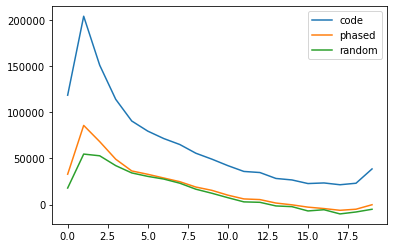

In [40]:
plt.plot(get_psf_vol(z_vols).sum(-1).sum(-1), label='code')
plt.plot(get_psf_vol(z_volsp).sum(-1).sum(-1), label='phased')
plt.plot(get_psf_vol(z_volsr).sum(-1).sum(-1), label='random')
plt.legend()